In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [2]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [3]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2051.000000,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03
mean,3144.884951,-9.916647e-01,1.357625e-07,8.983636e-04,2.772001e-08,9.931020e-03,-7.613491e-08,1.678592e-11
std,1811.726067,1.058217e-09,1.202943e-07,5.307901e-09,2.456665e-08,3.606267e-09,6.736846e-08,8.925691e-13
min,9.177680,-9.916647e-01,-8.264015e-11,8.983543e-04,-1.957939e-11,9.931014e-03,-2.261367e-07,1.380825e-11
25%,1577.031315,-9.916647e-01,2.668074e-08,8.983590e-04,5.438768e-09,9.931017e-03,-1.280591e-07,1.618974e-11
50%,3144.884951,-9.916647e-01,1.027174e-07,8.983636e-04,2.097238e-08,9.931020e-03,-5.764007e-08,1.676073e-11
75%,4712.738586,-9.916647e-01,2.282766e-07,8.983682e-04,4.661922e-08,9.931023e-03,-1.495125e-08,1.737429e-11
max,6280.592222,-9.916647e-01,4.033941e-07,8.983727e-04,8.238304e-08,9.931027e-03,-5.776291e-12,2.054861e-11


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

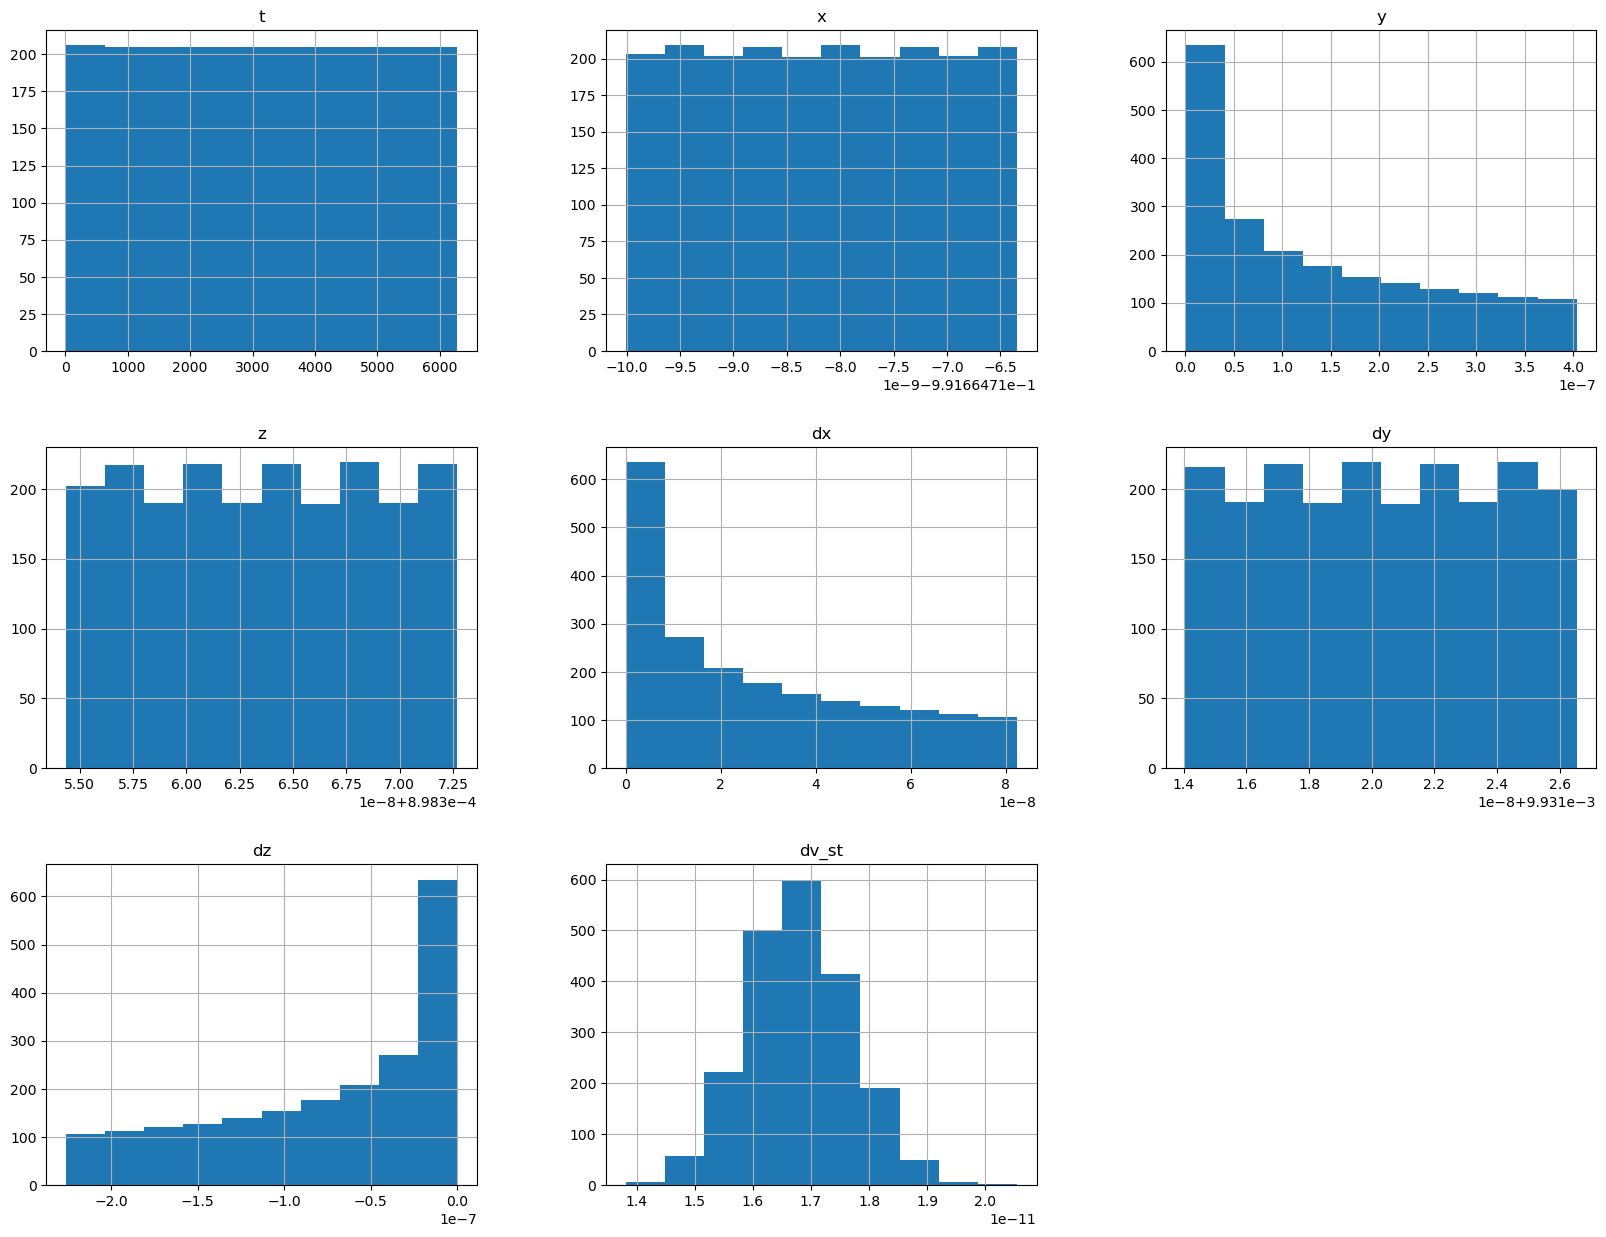

In [4]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Visualizing Data

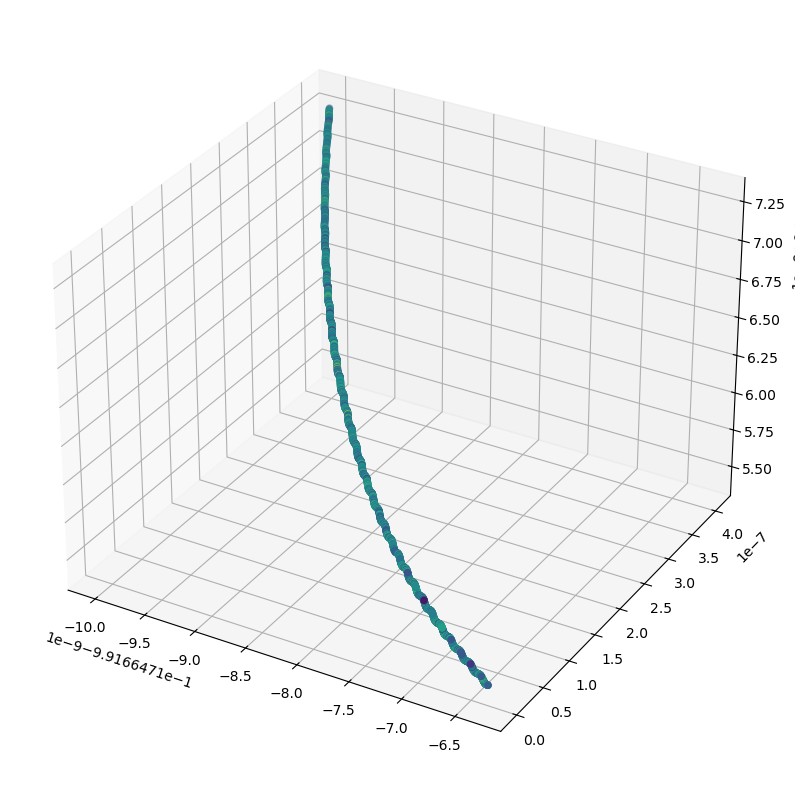

In [5]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [6]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
y        0.005996
dx       0.005976
dy       0.005230
z        0.004507
x       -0.005077
dz      -0.006023
Name: dv_st, dtype: float64

array([[<Axes: xlabel='y', ylabel='y'>, <Axes: xlabel='dx', ylabel='y'>,
        <Axes: xlabel='dz', ylabel='y'>,
        <Axes: xlabel='dv_st', ylabel='y'>],
       [<Axes: xlabel='y', ylabel='dx'>,
        <Axes: xlabel='dx', ylabel='dx'>,
        <Axes: xlabel='dz', ylabel='dx'>,
        <Axes: xlabel='dv_st', ylabel='dx'>],
       [<Axes: xlabel='y', ylabel='dz'>,
        <Axes: xlabel='dx', ylabel='dz'>,
        <Axes: xlabel='dz', ylabel='dz'>,
        <Axes: xlabel='dv_st', ylabel='dz'>],
       [<Axes: xlabel='y', ylabel='dv_st'>,
        <Axes: xlabel='dx', ylabel='dv_st'>,
        <Axes: xlabel='dz', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

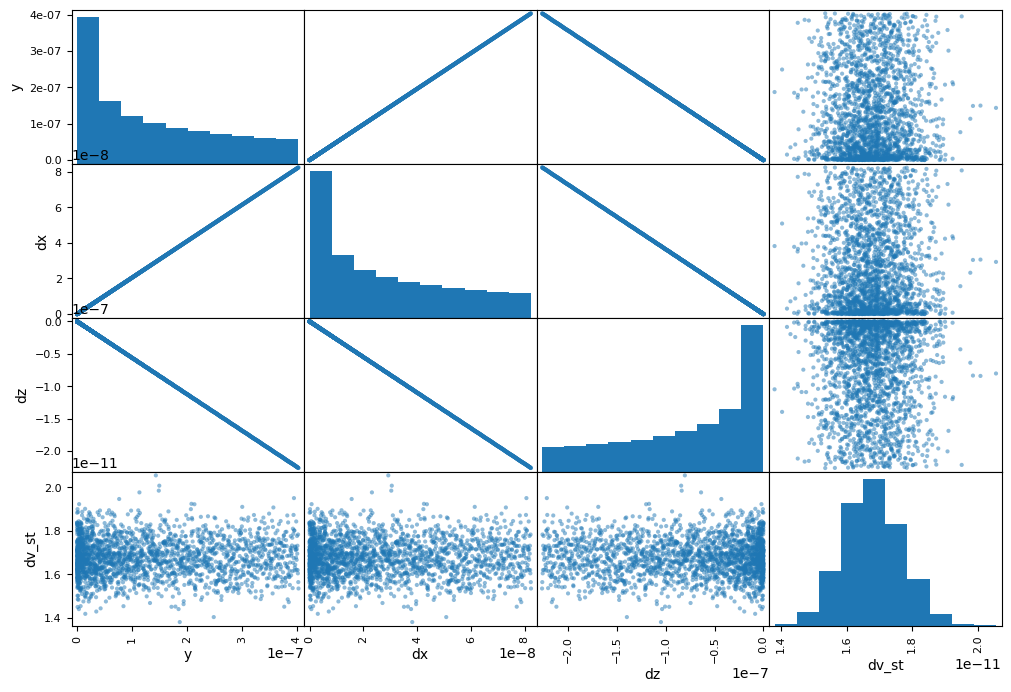

In [7]:
#attributes = ["angle", "x", "dx", "dv_st"]
attributes = ["y", "dx", "dz", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

y, dx and dz are perfectly correlated!!!

# Prepare the Data for Machine Learning Algorithms

## Create a Train/Test Set

In [28]:
# Let's separate the predictors and the labels

# Drop dx and dz features, since they are almost proportional to y
#maneuvers_predictors = maneuvers.drop(["dx", "dz", "dv_st"], axis=1)

maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz
0,-0.991665,6.991149e-12,0.000898,-8.695164e-12,0.009931,-5.776291e-12
1,-0.991665,7.582888e-12,0.000898,-9.260348e-12,0.009931,-8.976603e-12
2,-0.991665,6.975162e-12,0.000898,-8.756346e-12,0.009931,-1.269843e-11
3,-0.991665,5.375805e-12,0.000898,-9.247733e-12,0.009931,-1.694721e-11
4,-0.991665,2.762325e-12,0.000898,-9.419354e-12,0.009931,-2.170409e-11


## Create Train/Test/Validation Sets

In [29]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(1230, 6)
(411, 6)
(410, 6)


,x,y,z,dx,dy,dz
1397,-0.991665,1.891094e-07,0.000898,3.861135e-08,0.009931,-1.059409e-07
1291,-0.991665,1.617066e-07,0.000898,3.302141e-08,0.009931,-9.072285e-08
172,-0.991665,3.446398e-09,0.000898,6.923273e-10,0.009931,-1.924301e-09
357,-0.991665,1.327044e-08,0.000898,2.703719e-09,0.009931,-7.509209e-09
1876,-0.991665,3.383940e-07,0.000898,6.910766e-08,0.009931,-1.897238e-07


In [30]:
# Scale all the features. This transforms data type from dataframe to numpy array.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.31775582, 0.4693491 , 0.67985847, 0.46925454, 0.68512667,
        0.53108187],
       [0.36906761, 0.40136806, 0.6277033 , 0.40135283, 0.63434493,
        0.59844607],
       [0.91725594, 0.00875487, 0.08421867, 0.00864762, 0.08206994,
        0.99152163],
       [0.82527941, 0.03312643, 0.17066647, 0.03308023, 0.17780588,
        0.96679948],
       [0.08480078, 0.83969536, 0.91530546, 0.83969683, 0.91576774,
        0.16020855]])

In [31]:
# Try PCA of data
from sklearn.decomposition import PCA
pca_pred = PCA(n_components=2, whiten=True)   # PCA of predictors
principalComponents_pred = pca_pred.fit_transform(X_train_scaled)
print('Explained variability per principal component: {}'.format(pca_pred.explained_variance_ratio_))

# X_train_scaled = pca_pred.transform(X_train_scaled)
# X_valid_scaled = pca_pred.transform(X_valid_scaled)
# X_test_scaled = pca_pred.transform(X_test_scaled)
# X_train_scaled[:5]

Explained variability per principal component: [0.98474351 0.01520683]


In [32]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)

<Figure size 640x480 with 0 Axes>

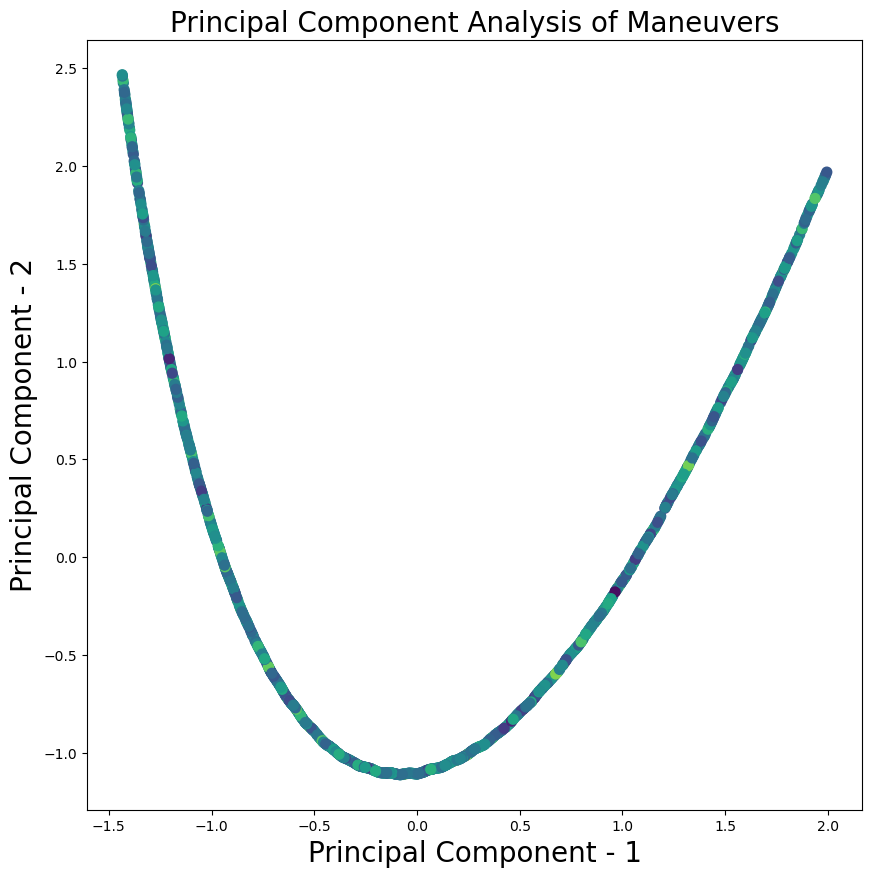

In [33]:
# Plot results of PCA
plt.figure()
plt.figure(figsize=(10,10))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Maneuvers",fontsize=20)
plt.scatter(principalComponents_pred[:, 0], principalComponents_pred[:, 1], c=y_train_scaled, s = 50)

From the above picture, it is seems that (PC1, PC2) only do not allow to distinguish dv. 

In [34]:
import joblib
joblib.dump(scaler, 'scaler_supervised.gz')
joblib.dump(scaler_target, 'scaler_target_supervised.gz')

['scaler_target_supervised.gz']

# Select and Train a Model

## Training and Evaluating on the Training Set

In [35]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [36]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.00016256552371308696

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [37]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = tree_reg.predict(X_train_scaled)
tree_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

NOW THIS IS MUCH BETTER!!

In [38]:
#Let's try it out on 5 instances from the test set
some_data = X_test_scaled[10:20]
some_labels = y_test_scaled[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [0.5219553983474738, 0.48802055986956683, 0.5514687594992682, 0.4560477519551225, 0.3596871804791779, 0.3576422472158516, 0.43333241219222396, 0.5144665211263719, 0.17415093818221994, 0.7343521154005583]
Labels: [array([0.45814795]), array([0.53187609]), array([0.62588775]), array([0.44839307]), array([0.61859231]), array([0.55141349]), array([0.29496781]), array([0.42642385]), array([0.44198193]), array([0.3982922])]


In [39]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_train_scaled)
forest_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.05722992420738699

## Polynomial Regression

In [40]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(X_train_scaled)
#print(X_train_scaled.head())
print(maneuvers_pred_poly[0])
#poly_features.get_feature_names_out(['x','y','z','dy'])

[0.31775582 0.4693491  0.67985847 0.46925454 0.68512667 0.53108187
 0.10096876 0.14913841 0.21602899 0.14910836 0.21770299 0.16875435
 0.22028858 0.31909096 0.2202442  0.32156359 0.2492628  0.46220754
 0.31902667 0.46578917 0.36106051 0.22019982 0.3214988  0.24921258
 0.46939856 0.36385836 0.28204795]


In [41]:
my_lin_reg = LinearRegression()
my_lin_reg.fit(maneuvers_pred_poly, y_train_scaled)
print(my_lin_reg.coef_)
maneuvers_predictions = my_lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

[[   366.05324572  31803.04711214    127.94985199 -36637.92719578
     220.87063198  -4846.24038161  -2028.01840323 -15990.43619236
   -1517.40258968  18512.24955228  -2483.80050572   2549.79854742
   16950.57656722  -5992.13700341 -38145.82648521  -9776.54664868
   -4132.53713172   -283.72768622   6937.45686075   -929.14713471
     955.9185815   21419.2566899   11317.57163625   4567.39001896
    -760.39792358   1558.37950258    208.72991544]]


6.908102292973808e-05

## SVM Regression

In [42]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(X_train_scaled, y_train_scaled)
maneuvers_predictions = svm_poly_reg.predict(X_train_scaled)
svm_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1329262370981077

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Random Forest model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [43]:
from sklearn.model_selection import cross_val_score
#tree_reg = DecisionTreeRegressor()
#forest_reg = RandomForestRegressor()
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, maneuvers_pred_poly, y_train_scaled,
scoring="neg_root_mean_squared_error", cv=5)
poly_rmse_scores = -scores

In [44]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(poly_rmse_scores)

Scores: [6.99888647e-05 6.56585327e-05 7.38534295e-05 7.49167337e-05
 6.95498416e-05]
Mean: 7.079348044877946e-05
Standard deviation: 3.3144000311119763e-06


## Evaluate Model on Test Set

In [45]:
maneuvers_pred_poly = poly_features.fit_transform(X_test_scaled)
maneuvers_predictions = my_lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_test_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6.863913368742633e-05

## Persist model

In [46]:
# Persist the model for future use (see correction_module.py) without having to retrain.
# Here you can replace pickle with joblib or cloudpickle
from pickle import dump
with open("model_supervised.pkl", "wb") as f:
    dump(my_lin_reg, f, protocol=5)